In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter

# Load your data
data = np.load('HF-448_V5B_1.h5_3.npy')

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def preprocess_spectrum(spectrum):
    spectrum = np.concatenate((spectrum[104:907], spectrum[1374:]))
    # Calculate the baseline
    baseline = baseline_als(spectrum, 10000, 0.01)

    # Subtract the baseline
    corrected_spectrum = spectrum - baseline

    # Apply Savitzky-Golay filtering
    filtered_spectrum = savgol_filter(corrected_spectrum, 11, 3)

    return filtered_spectrum

def preprocess_spectrum_raw(spectrum):
    # Clip negative values at 0
    spectrum = np.clip(spectrum, 0, None)
    # Remove the specified ranges
    spectrum = np.concatenate((spectrum[104:907], spectrum[1374:]))
    return spectrum

def load_and_process_raw_data(raw_data_path):
    # Load raw data
    raw_data = np.load(raw_data_path)
    num_x, num_y, _ = raw_data.shape

    # Process raw data
    num_spectral_points = raw_data.shape[2] - (104 + (1374 - 907))
    processed_raw_data = np.empty((num_x, num_y, num_spectral_points))

    for i in range(num_x):
        for j in range(num_y):
            processed_raw_data[i, j, :] = preprocess_spectrum_raw(raw_data[i, j, :])

    # Flatten the data and add x and y coordinates
    flattened_data = processed_raw_data.reshape(-1, num_spectral_points)
    x_coords, y_coords = np.meshgrid(np.arange(num_x), np.arange(num_y), indexing='ij')
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()

    # Combine the spectra with their corresponding x and y coordinates
    final_raw_data = np.column_stack((flattened_data, x_coords, y_coords))
    return final_raw_data

# data is a 3D array with shape (X, Y, 1738)
num_x, num_y, _ = data.shape
num_spectral_points = data.shape[2] - (104 + (1374 - 907))
preprocessed_data = np.empty((num_x, num_y, num_spectral_points))

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        preprocessed_data[i, j, :] = preprocess_spectrum(data[i, j, :])

# Normalize the entire dataset so that the sum of all intensities is 1
total_intensity_sum = np.sum(preprocessed_data)
preprocessed_data /= total_intensity_sum

# Flatten the data and add x and y coordinates
flattened_data = preprocessed_data.reshape(-1, num_spectral_points)
x_coords, y_coords = np.meshgrid(np.arange(num_x), np.arange(num_y), indexing='ij')
x_coords = x_coords.flatten()
y_coords = y_coords.flatten()

# Combine the spectra with their corresponding x and y coordinates
final_data = np.column_stack((flattened_data, x_coords, y_coords))

raw_data_path = 'HF-448_V5B_1.h5_3.npy'
final_raw_data = load_and_process_raw_data(raw_data_path)

# Save to a CSV file
def save_preprocessed_data(final_data, filename='preprocessed_raman_data.csv'):
    columns = [f'wavenumber_{i}' for i in range(final_data.shape[1] - 2)] + ['x', 'y']
    df = pd.DataFrame(final_data, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Preprocessed data has been exported to '{filename}'.")

# Save preprocessed data to CSV
save_preprocessed_data(final_data)

def save_raw_data(final_data, filename='raw_clipped_raman_data.csv'):
    columns = [f'wavenumber_{i}' for i in range(final_data.shape[1] - 2)] + ['x', 'y']
    df = pd.DataFrame(final_data, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Preprocessed data has been exported to '{filename}'.")

save_raw_data(final_raw_data)

Preprocessed data has been exported to 'preprocessed_raman_data.csv'.
Preprocessed data has been exported to 'raw_clipped_raman_data.csv'.


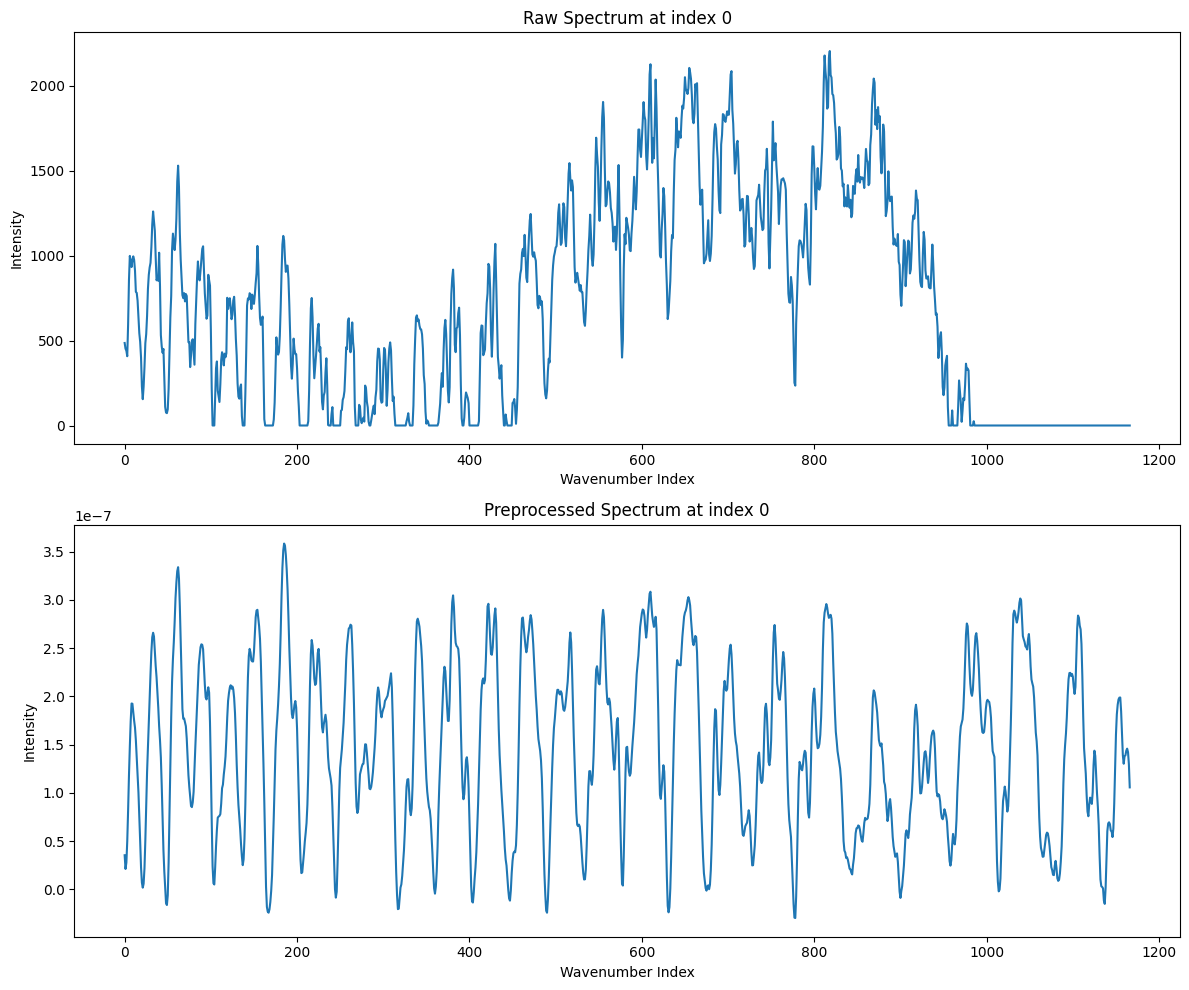

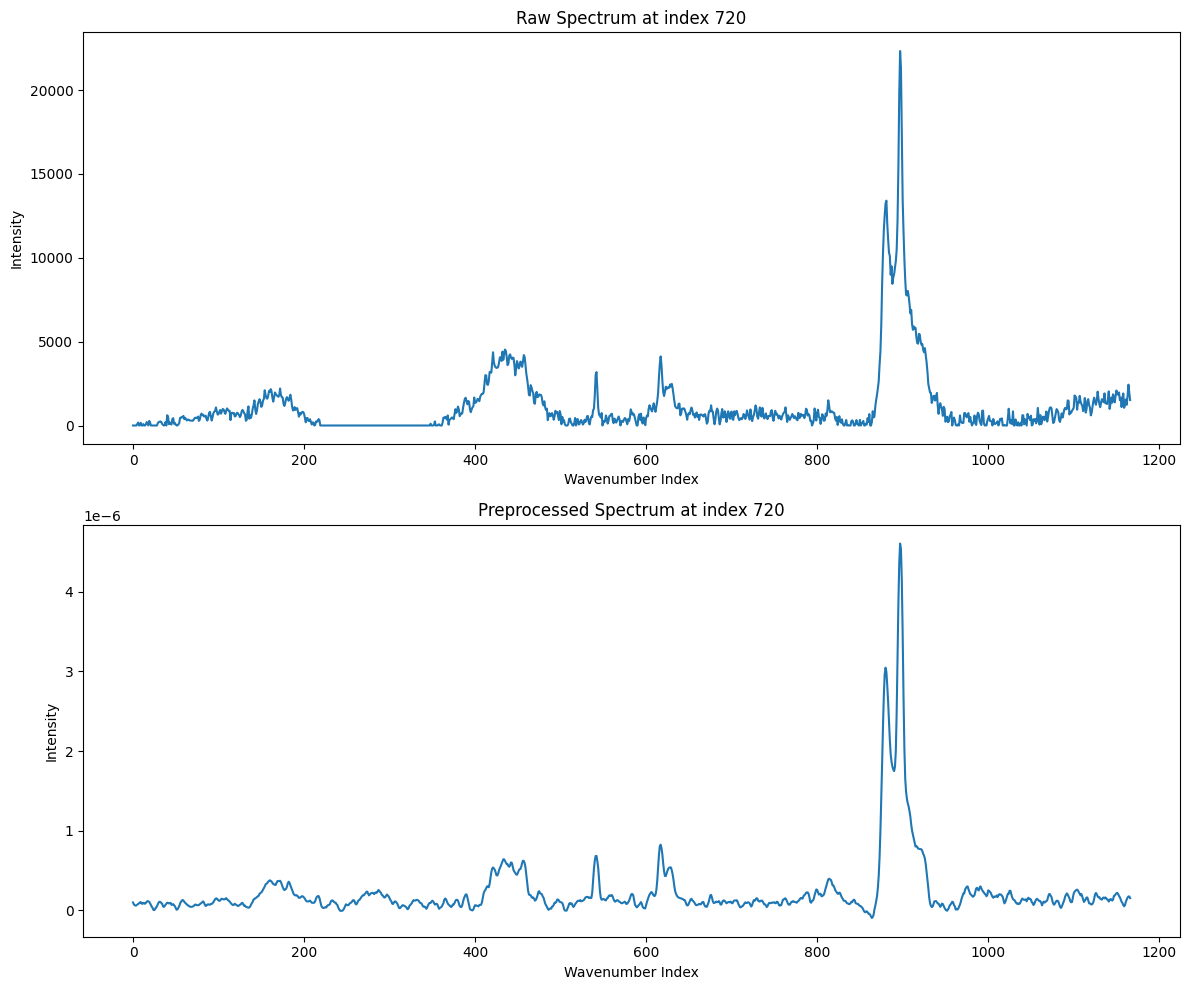

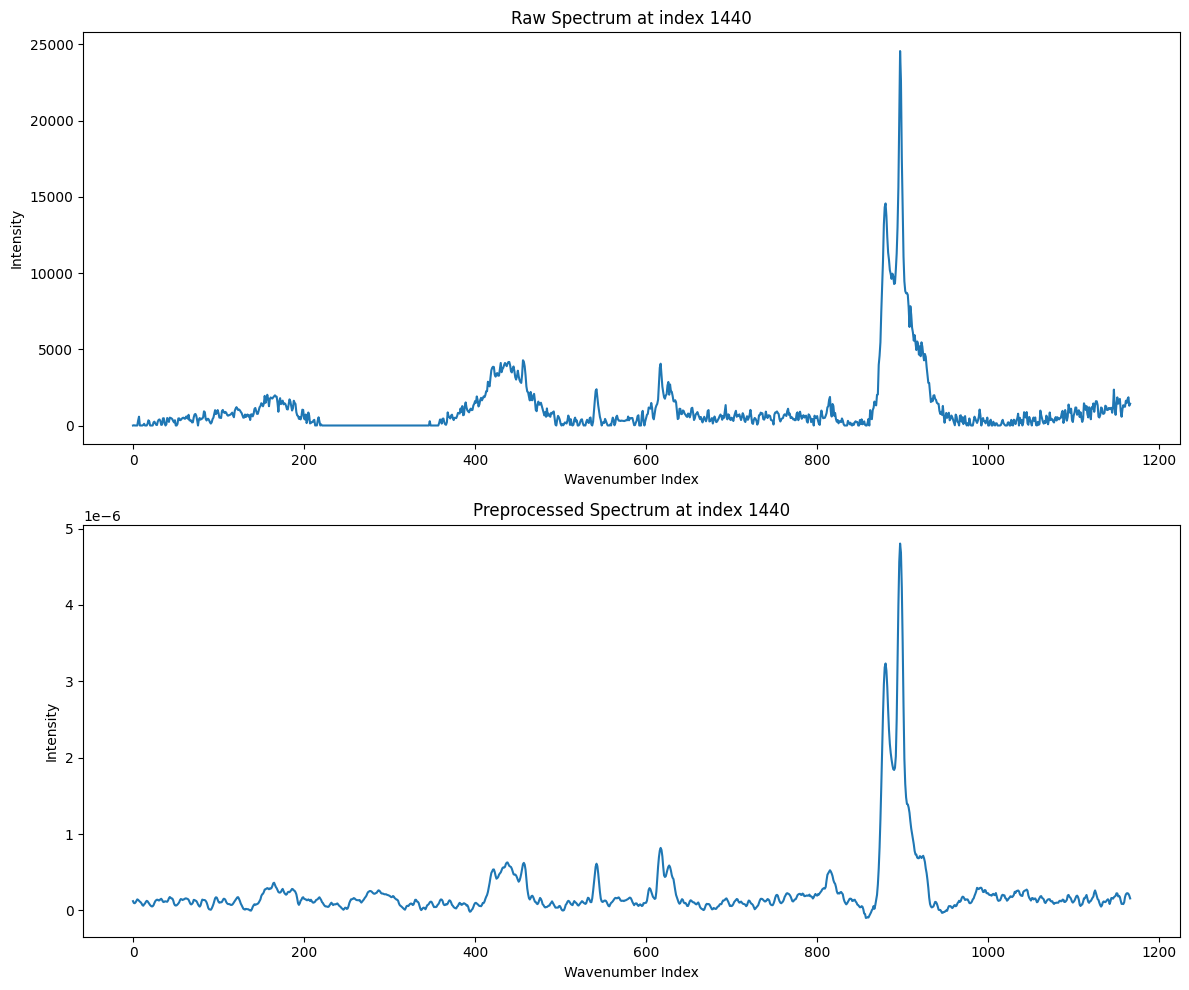

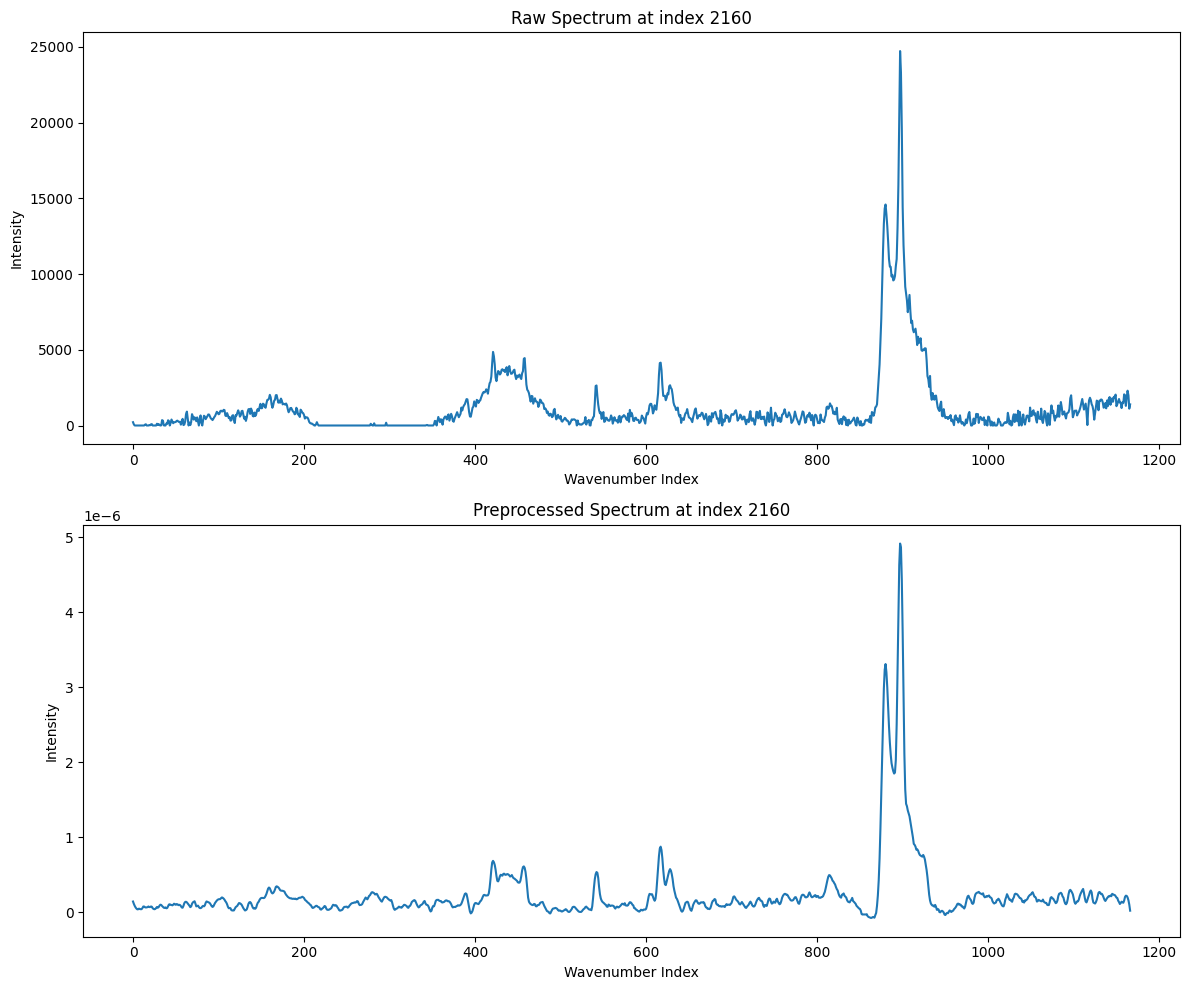

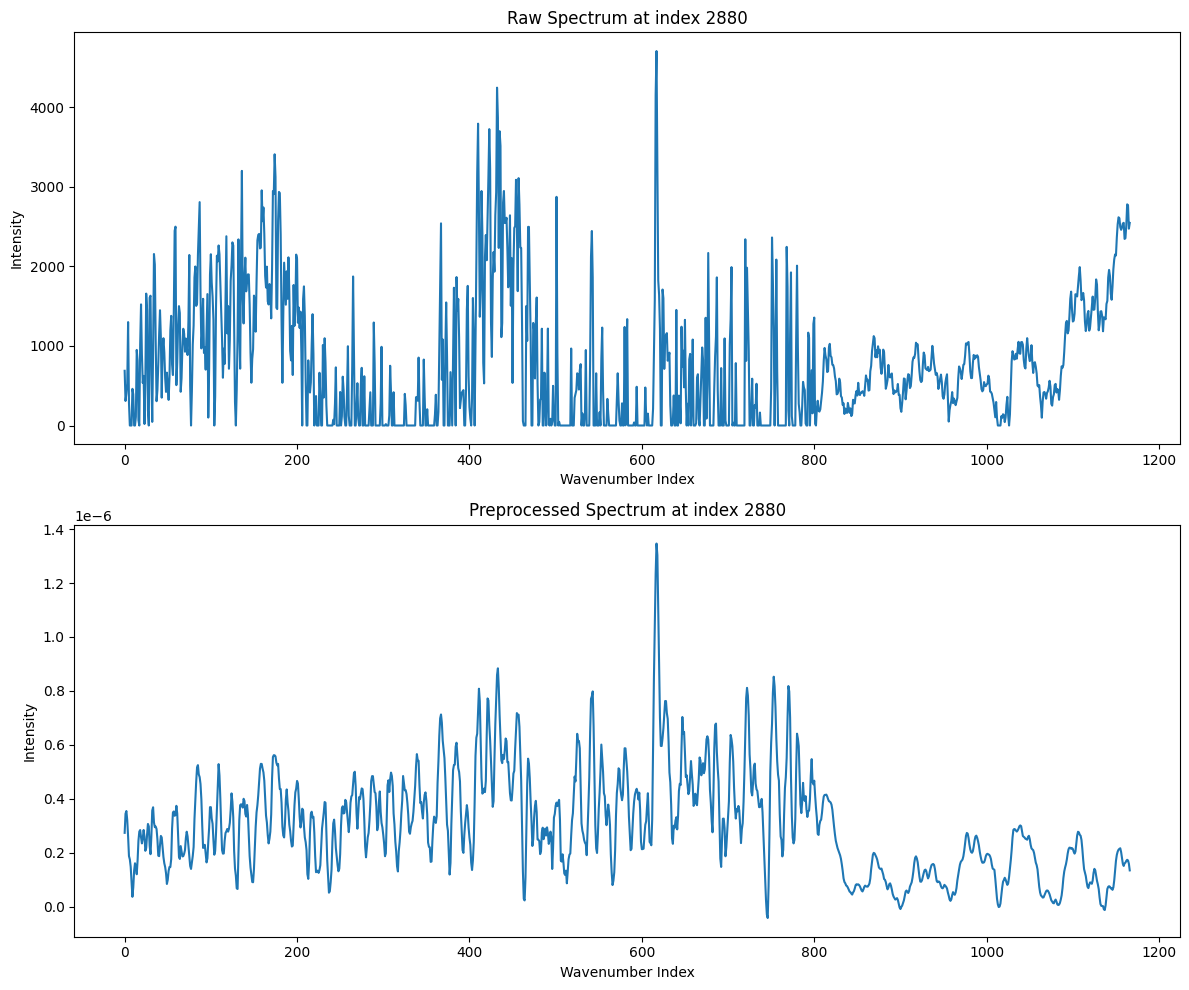

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def preprocess_spectrum(spectrum):
    # Clip negative values at 0
    spectrum = np.clip(spectrum, 0, None)
    # Remove the specified ranges
    spectrum = np.concatenate((spectrum[104:907], spectrum[1374:]))
    return spectrum

def load_and_process_raw_data(raw_data_path):
    # Load raw data
    raw_data = np.load(raw_data_path)
    num_x, num_y, _ = raw_data.shape

    # Process raw data
    num_spectral_points = raw_data.shape[2] - (104 + (1374 - 907))
    processed_raw_data = np.empty((num_x, num_y, num_spectral_points))

    for i in range(num_x):
        for j in range(num_y):
            processed_raw_data[i, j, :] = preprocess_spectrum(raw_data[i, j, :])

    # Flatten the data and add x and y coordinates
    flattened_data = processed_raw_data.reshape(-1, num_spectral_points)
    x_coords, y_coords = np.meshgrid(np.arange(num_x), np.arange(num_y), indexing='ij')
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()

    # Combine the spectra with their corresponding x and y coordinates
    final_raw_data = np.column_stack((flattened_data, x_coords, y_coords))
    return final_raw_data

def load_preprocessed_data(preprocessed_data_path):
    # Load preprocessed data
    preprocessed_data = pd.read_csv(preprocessed_data_path)
    return preprocessed_data.values

def visualize_spectra_separately(raw_spectrum, preprocessed_spectrum, index):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    axs[0].plot(raw_spectrum[:-2])
    axs[0].set_title(f'Raw Spectrum at index {index}')
    axs[0].set_xlabel('Wavenumber Index')
    axs[0].set_ylabel('Intensity')

    axs[1].plot(preprocessed_spectrum[:-2])
    axs[1].set_title(f'Preprocessed Spectrum at index {index}')
    axs[1].set_xlabel('Wavenumber Index')
    axs[1].set_ylabel('Intensity')

    plt.tight_layout()
    plt.show()

def main():
    raw_data_path = 'HF-448_V5B_1.h5_3.npy'
    preprocessed_data_path = 'preprocessed_raman_data.csv'

    # Load and process raw data
    final_raw_data = load_and_process_raw_data(raw_data_path)

    # Load preprocessed data
    final_preprocessed_data = load_preprocessed_data(preprocessed_data_path)

    # Visualize a few spectra before and after preprocessing
    for idx in range(0, final_raw_data.shape[0], int(final_raw_data.shape[0] / 5)):
        raw_spectrum = final_raw_data[idx]
        preprocessed_spectrum = final_preprocessed_data[idx]
        visualize_spectra_separately(raw_spectrum, preprocessed_spectrum, idx)

if __name__ == "__main__":
    main()

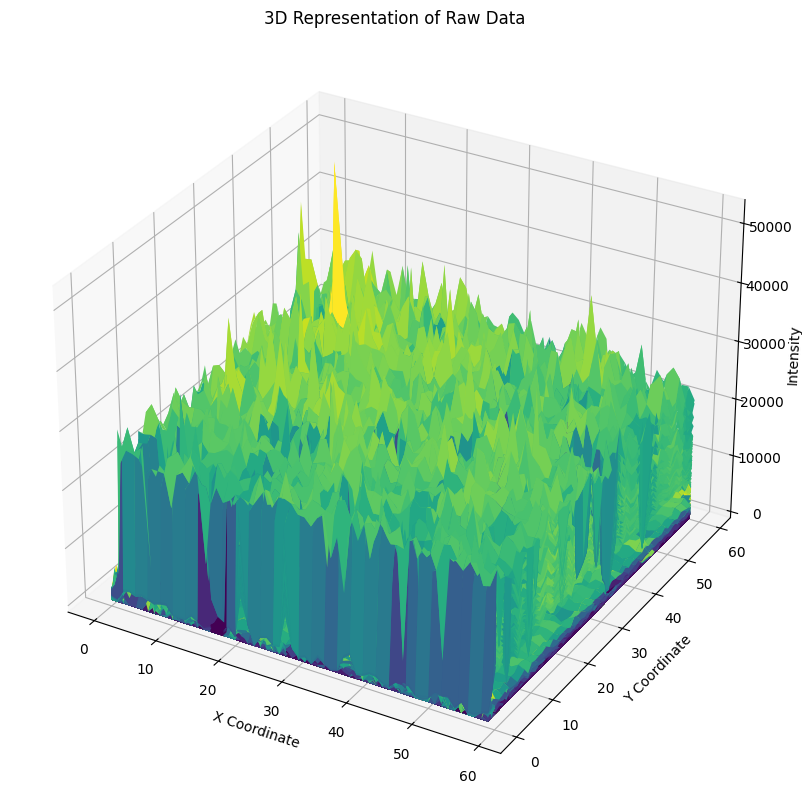

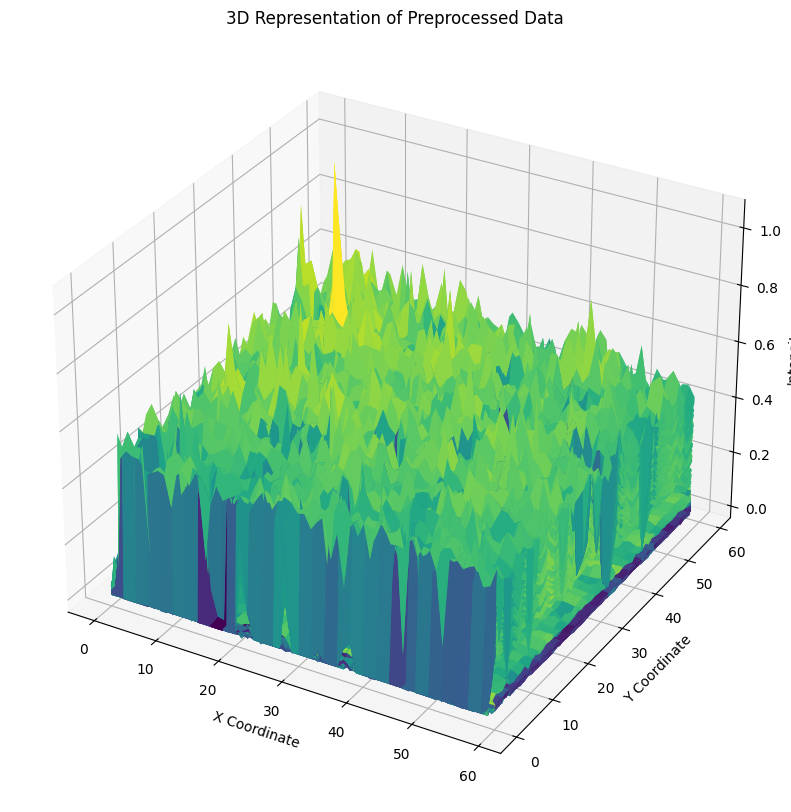

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter

def preprocess_spectrum(spectrum):
    # Clip negative values at 0
    spectrum = np.clip(spectrum, 0, None)
    # Remove the specified ranges
    spectrum = np.concatenate((spectrum[104:907], spectrum[1374:]))
    return spectrum

def load_and_process_raw_data(raw_data_path):
    # Load raw data
    raw_data = np.load(raw_data_path)
    num_x, num_y, _ = raw_data.shape

    # Process raw data
    num_spectral_points = raw_data.shape[2] - (104 + (1374 - 907))
    processed_raw_data = np.empty((num_x, num_y, num_spectral_points))

    for i in range(num_x):
        for j in range(num_y):
            processed_raw_data[i, j, :] = preprocess_spectrum(raw_data[i, j, :])

    return processed_raw_data

def load_preprocessed_data(preprocessed_data_path):
    # Load preprocessed data
    preprocessed_data = pd.read_csv(preprocessed_data_path)
    return preprocessed_data.iloc[:, :-2].values  # Exclude x and y columns

def create_3d_plot(data, title):
    num_x, num_y, num_spectral_points = data.shape
    x = np.arange(num_x)
    y = np.arange(num_y)
    X, Y = np.meshgrid(x, y)
    Z = data.reshape(num_x * num_y, num_spectral_points)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_spectral_points):
        ax.plot_surface(X, Y, Z[:, i].reshape(num_x, num_y), cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Intensity')
    plt.show()

def main():
    raw_data_path = 'HF-448_V5B_1.h5_3.npy'
    preprocessed_data_path = 'preprocessed_raman_data.csv'

    # Load and process raw data
    raw_data = load_and_process_raw_data(raw_data_path)

    # Load preprocessed data
    preprocessed_data = load_preprocessed_data(preprocessed_data_path)

    # Create 3D plots
    create_3d_plot(raw_data, '3D Representation of Raw Data')
    create_3d_plot(preprocessed_data.reshape(60, 60, -1), '3D Representation of Preprocessed Data')

if __name__ == "__main__":
    main()

In [5]:
%pip install numpy pandas matplotlib scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
